In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import SpectralClustering

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
dt = 0.004
num_steps = 501
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([501, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

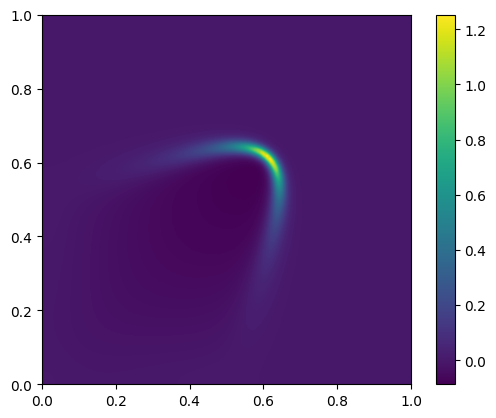

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = u_dot

In [8]:
clustering = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0).fit(coords)

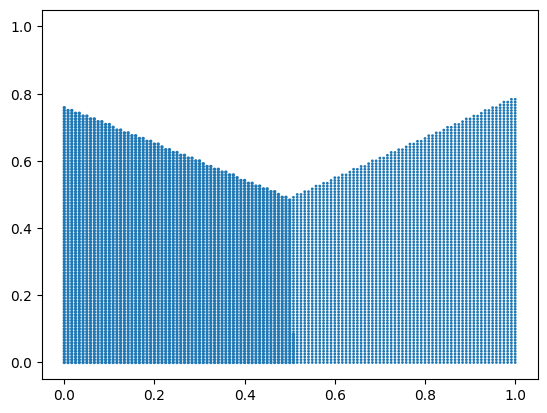

In [9]:
plt.scatter(coords_x, coords_y,clustering.labels_)

In [10]:
clustering.labels_

array([2, 2, 2, ..., 0, 0, 0])

In [11]:
index_0 = torch.tensor(np.where(clustering.labels_ == 0)[0], device=device)
index_1 = torch.tensor(np.where(clustering.labels_ == 1)[0], device=device)
index_2 = torch.tensor(np.where(clustering.labels_ == 2)[0], device=device)
group_indices = [index_0, index_1, index_2]


In [12]:
N = datas.shape[1]
n = 20
m = 3
mu = int(np.ceil(N/20))
neighbours = lib.utils.topk_neighbours(coords, mu)

In [13]:
batch_size = 20
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [14]:
ed = lib.nrbs_n_m.EncoderDecoder(N=N, n=n, mu=mu, m=m, neighbours=neighbours, group_indices=group_indices, device=device)

In [15]:
encoded = ed.nrbs.encode(datas[:15].to(device))

In [25]:
encoded.shape

torch.Size([15, 20])

In [16]:
decoded = ed.nrbs.decode(encoded)

In [17]:
decoded.shape

torch.Size([15, 14641])

In [16]:
bandwidth = ed.nrbs.get_bandwidth(encoded)
bandwidth.shape

torch.Size([15, 20, 3])

In [17]:
vmap_bubble = vmap(ed.nrbs.bubble, in_dims=0)
vmap_vmap_bubble = vmap(vmap_bubble, in_dims=0)
vmap_vmap_vmap_bubble = vmap(vmap_vmap_bubble, in_dims=0)

In [18]:
bubbles = vmap_vmap_vmap_bubble(bandwidth)

In [19]:
bubbles.shape

torch.Size([15, 20, 3, 733])

In [20]:
# for the ith group
i_bubble = bubbles[:, :, 0, :]

In [21]:
node_idxs = torch.linspace(0, N - 1, N, dtype=torch.long)
basises = ed.nrbs.decoder[:, ed.nrbs.getNeighbours(node_idxs)]

In [24]:
ed.nrbs.get_group_idx_smoothed_basis(0, basises, bubbles).shape

torch.Size([20, 15, 5359])

In [57]:
basises.shape

torch.Size([20, 14641, 733])

In [58]:
i_basis = basises[:, ed.nrbs.group_indices[0], :]

In [59]:
# n x mu x N/m
i_basis = i_basis.permute((0, 2, 1))

# n x batch x mu
i_bubble = i_bubble.permute((1, 0, 2))

In [61]:
i_basis.shape

torch.Size([20, 733, 5359])

In [60]:
i_bubble.shape

torch.Size([20, 15, 733])

In [62]:
i_smoothed = torch.bmm(i_bubble, i_basis)

In [69]:
i_smoothed.shape

torch.Size([20, 15, 5359])

In [65]:
test = torch.zeros((n,15,N),device=device)

In [67]:
test[:,:,ed.nrbs.group_indices[0]] = i_smoothed

In [12]:
decoded = ed.nrbs.decode(encoded)

In [13]:
node_idxs = torch.linspace(0, N - 1, N, dtype=torch.long)
node_idxs.shape

torch.Size([14641])

In [14]:
ed.nrbs = torch.load('models/nrbs_n_1.pth')

In [18]:
ed.train(train_data_loader=train_data, epochs=1)

 28%|██▊       | 7/25 [00:03<00:08,  2.09it/s]

In [16]:
ed.nrbs = torch.load('models/nrbs_n_1.pth')

In [17]:
approximates = ed(datas[499:501].to(device))
approximates.shape

torch.Size([1, 14641])

In [18]:
approximates[0]

tensor([ 5.5680e-04,  1.1103e-03,  1.1119e-03,  ..., -1.5321e-04,
         8.6843e-06,  8.8763e-05], device='cuda:0', grad_fn=<SelectBackward0>)

In [19]:
datas[489]

tensor([2.5750e-03, 2.4500e-03, 2.3000e-03,  ..., 6.4447e-30, 6.4447e-30,
        9.2545e-30])

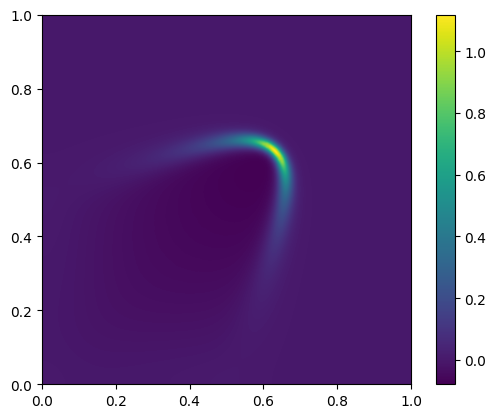

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[499].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

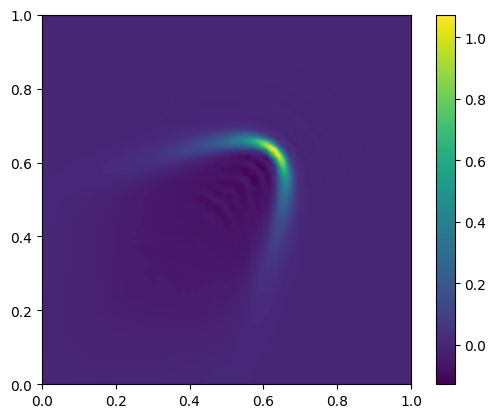

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

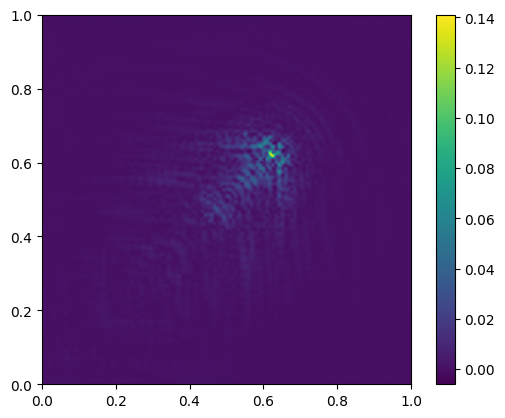

In [22]:
err = abs(datas[499] - approximates[0].detach().cpu())

# data coordinates and values
z = err.tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [23]:
bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
bws = torch.sigmoid(bws)

In [24]:
# bws = ed.nrbs.get_bandwidth(ed.nrbs.encode(datas[499:501].to(device)))

In [25]:
# # data coordinates and values
# z = bws[0].detach().cpu().tolist()

# # target grid to interpolate to
# xi = yi = np.linspace(0,1.0,1200)
# xi,yi = np.meshgrid(xi,yi)

# # set mask
# # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# # interpolate
# zi = griddata((x,y),z,(xi,yi),method='cubic')

# plt.imshow(zi,origin='lower', extent=[0,1,0,1])
# plt.colorbar()